# Hyperparameter optimization

Grand et al data

Hyperparameter optimization on a development set.

# Reading the data

## GloVE

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
glove_path = "glove/glove.42B.300d.zip"
glove_file = "glove.42B.300d.txt"

feature_dim = 300

word_vectors = { }

with zipfile.ZipFile(glove_path) as azip:
    with azip.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

## Grand features

In [3]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Function for reading a specific Grand dataset

In [4]:
# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    nspeakers = len(df.columns) -1
    df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

# Function for running crossvalidation

In [5]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    
    rng = np.random.default_rng(seed = 3)
    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir, 
                                                                                            grandfeatures_df)


            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = rng.integers(low = 0, high = method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"],
                                                                                       random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


# Function for aggregating crossvalidation results

We assume results that are dictionaries. 

First, a function for aggregating results by particular labels, into a single dictionary. For example, when results are aggregated by category and feature, the result will be a dictionary whose keys are category/feature tuples, and the values are lists of result dictionaries. 

Second, a function that computes mean, median, and standard deviation, over a list of result dictionaries, for a given labels.

In [6]:
from collections import defaultdict
import statistics

# given a list of results dictionaries, 
# group them by the given dictionary keys
def eval_aggregate_by(evals, keylabels):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        key = tuple([str(e[k]) for k in keylabels])
        bydataset_eval[ key ].append(e)
        
    return bydataset_eval


# given a list of results dictionaries,
# compute mean, median and standard deviation over values for a particular key
def eval_summary_by(evals, keylabel):
    vals = [e[keylabel] for e in evals if e[keylabel] is not None]
    
    return (statistics.mean(vals), statistics.median(vals), statistics.stdev(vals))

# given a dictionary of results (parameters -> result dictionary list),
# * for each parameter setting, aggregate by cateogy and feature
# * for each category/feature, compute mean ocp and mse values
# * for the parameter setting, compute mean and sd ocp and mse over all category/feature pairs
def eval_hyper(results, parameternames):
    # output dictionary
    results_byparam = [ ]

    # iterate over parameter settings
    for theseresults in results.values():
        # extract parameters
        this_dict = dict([(par, theseresults[0][par]) for par in parameternames])
        
        # aggregate by condition = by category and feature
        results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
        
        # compute mean ocp and mse values.
        # ocp: we use mean for each condition.
        # mse: we use median(!!) for each condition
        ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
        mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]

        # compute mean and standard deviation over ocps and mses
        this_dict["ocp_mean"] = statistics.mean(ocps)
        this_dict["ocp_sd"] = statistics.stdev(ocps)
        this_dict["msemed_mean"] = statistics.mean(mses)
        this_dict["msemed_sd"] = statistics.stdev(mses)
        
        results_byparam.append(this_dict)
        
    return results_byparam


# Making a development set

In [7]:
filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]

import random
random.seed(789)
devset = random.sample(filenames, 6)
[ filename[:-4].split("_") for filename in devset]

[['cities', 'danger'],
 ['states', 'political'],
 ['animals', 'wetness'],
 ['cities', 'intelligence'],
 ['animals', 'weight'],
 ['names', 'age']]

In [8]:
num_randseeds = 3

# Determining hyperparameters

## Fitted dimensions with seeds as words: offset, jitter

First experiments looked like there was a lot of variance in result with different random seeds. To check into this, we run the hyperparameter tests 10 times with different random seeds. We then look at mean and standard deviation of the two measures we focus on: mean OC_p and median MSE.

In [ ]:
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=20)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            print(jval, oval)
            

            for r in theseresults:
                r.update({"offset":oval, "j": jval})
                results[ (str(oval), str(jval))].append(r)
    

In [ ]:
df = pd.DataFrame(eval_hyper(results, ["offset", "j"]))
df.head()


We plot mean OC_P values, with standard deviation. The differences in result are minimal compared to the error bars: It basically doesn't matter which value we pick. 

In [ ]:
%matplotlib inline
df[df.j == False].plot(y = "ocp_mean",x = "offset", yerr = "ocp_sd")

In [ ]:
df[df.j == True].plot(y = "ocp_mean", x = "offset", yerr = "ocp_sd")

We plot mean values of median MSE, with standard deviation. Here the difference in results is clearly dwarfed by the error bars: It does not matter at all which values we pick. 

In [ ]:
df[df.j == False].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

In [ ]:
df[df.j == True].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

### Parameters for seeds as words

Because all differences in values are dwarfed by differences in error bars, we pick a middle **offset = 1 and no jitter** (which is simpler than with jitter).

In [ ]:
df.sort_values(by = "ocp_mean", ascending = False).head(10)

In [ ]:
df.sort_values(by = "msemed_mean", ascending = True).head(10)

## Fitted dimensions with seeds as dimensions: alpha, averaging

We first run an exploration, with only one random seed.

In [ ]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.25, num=10)

results = defaultdict(list)

randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            print(alphaval, avgval)
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r)            



In [ ]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


In [ ]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

In [ ]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

In [ ]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

In [ ]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

We see that overall the performance is best, in terms of both OC_P and MSE, for small values of alpha, though again there is a large error bar. We explore the low range of alpha in more detail, both with and without averaging. 

In [ ]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.15, num=10)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            print(alphaval, avgval)
            
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r) 

In [ ]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


We again plot average OC_P mean and MSE median values, with error bars. 

In [ ]:
%matplotlib inline

df[df.avg == True].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

In [ ]:
df[df.avg == False].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

In [ ]:
df[df.avg == False].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

In [ ]:
df[df.avg == True].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

We again see large error bars, meaning that there is wide difference across sub-datasets. Still, low values of alpha seem best both in terms of OC_P and MSE. 

We again look at the numbers.

In [ ]:
df[df.avg == True].sort_values(by = 'ocp_mean', ascending = False).head(3)

In [ ]:
df[df.avg == False].sort_values(by = 'ocp_mean', ascending = False).head(3)

In [ ]:
df[df.avg == False].sort_values(by = 'msemed_mean').head(3)

In [ ]:
df[df.avg == True].sort_values(by = 'msemed_mean').head(3)

In terms of both OC_P and MSE, the best value is at **alpha = 0.02, with averaging over seeds.** 

# Combined model: seeds as words and dimensions

We fix jitter to be true, and averaging to be true, in order not to have too many conditions. We also fix offset to being 1.3, as before, as offset never makes much of a difference. We test different alpha values, with 3 random conditions. 

In [10]:
average_vals = [True]
alpha_vals= np.linspace(0.001, 0.15, num=10)
jitter_vals = [False]
offset_vals= [ 1.0 ]


results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    
                    print(alphaval, avgval, oval, jval)
            
            
                    for r in theseresults:
                        r.update({"alpha":alphaval, "avg": avgval, "offset": oval, "j": jval})
                        results[ (str(alphaval), str(avgval))].append(r) 



0.001 True 1.0 False 0.7014253380221352 2.003813796798592
0.017555555555555557 True 1.0 False 0.7377143413578513 1.033463947262511
0.03411111111111111 True 1.0 False 0.8155789680779466 0.5859567842418676
0.050666666666666665 True 1.0 False 0.8333665935315907 0.4428096770899327
0.06722222222222222 True 1.0 False 0.8287809834854258 0.47271787645404406
0.08377777777777778 True 1.0 False 0.8186188891270695 0.5738299166747012
0.10033333333333333 True 1.0 False 0.8147597099094187 0.6198996667180109
0.11688888888888889 True 1.0 False 0.8030129626287426 0.594161411121956
0.13344444444444445 True 1.0 False 0.7993724833488879 0.7846254973749158
0.15 True 1.0 False 0.8059986176835795 0.6431582087444617
0.001 True 1.0 False 0.7054862407688673 1.1993390490725058
0.017555555555555557 True 1.0 False 0.7655386484241454 0.7679232578221189
0.03411111111111111 True 1.0 False 0.8370360262443896 0.571653438560801
0.050666666666666665 True 1.0 False 0.8408030300983842 0.5554176764882943
0.06722222222222222 

In [11]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg", "offset", "j"]))
df.head()


,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,1.0,False,0.695803,0.061074,2.077080,0.732021
1,0.017556,True,1.0,False,0.750965,0.049402,1.122805,0.546613
2,0.034111,True,1.0,False,0.830723,0.026390,0.577268,0.162120
3,0.050667,True,1.0,False,0.834669,0.036087,0.539511,0.228127
4,0.067222,True,1.0,False,0.833856,0.032281,0.471075,0.189174


## Plotting the results



<AxesSubplot: xlabel='alpha'>

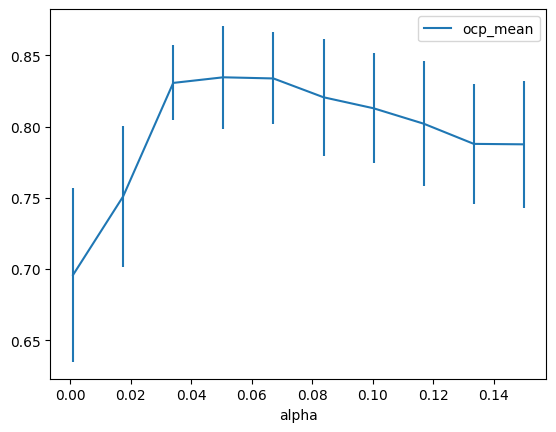

In [12]:
df.plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

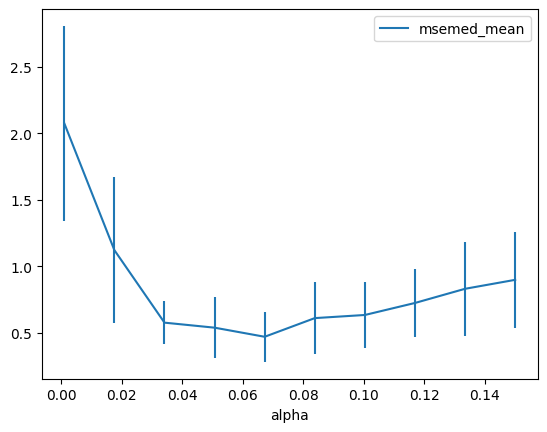

In [13]:
df.plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

In [14]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
3,0.050667,True,1.0,False,0.834669,0.036087,0.539511,0.228127
4,0.067222,True,1.0,False,0.833856,0.032281,0.471075,0.189174
2,0.034111,True,1.0,False,0.830723,0.026390,0.577268,0.162120
5,0.083778,True,1.0,False,0.820640,0.041083,0.611418,0.273689
6,0.100333,True,1.0,False,0.812893,0.038646,0.634985,0.248594


Both OC_P and MSE have a clear best value at **alpha = 0.05**. We use **averaging, no jitter, and an offset of 1.0**,